# Assignment 1

## This is a simple introduction to machine learning. Our goal is to train a emotional state classifier

## Marks will be awarded as follows:

## If performance on test data exceeds 25 percentile, 9.5/10 marks will be awarded
## If performance on test data tops the class, 10/10 marks will be awarded
## If performance on test data drops below 25 percentile, 9.5-X marks will be awarded, where X=(Z-Y)/3, with Y being the algorithm accuracy and Z being the 25th percentile accuracy

## Facial expression data is modified from https://www.kaggle.com/c/3364

### A csv file with facial expression data is provided.


In [1]:
# !pip install --default-timeout=100 opencv-python==4.2.0.34 

In [2]:
import pandas as pd
import numpy as np
import cv2
data_path = 'dataForClass.csv'
image_size=(48,48)

def load_data(data_path):
        data = pd.read_csv(data_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)

        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions
    
faces, emotions = load_data(data_path); 

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
faces, emotions = load_data(data_path)
test_size = 0.1
validation_size = 0.1
faces_train, faces_temp, emotions_train, emotions_temp = train_test_split(faces, emotions, test_size = test_size + validation_size)

faces_test, faces_val, emotions_test, emotions_val = train_test_split(faces_temp, emotions_temp, test_size = validation_size/(test_size + validation_size))

In [5]:
faces_train.shape

(18995, 48, 48, 1)

In [6]:
faces_test.shape

(2374, 48, 48, 1)

In [7]:
faces_val.shape

(2375, 48, 48, 1)

### A sample face

Emotion Labels [1 0 0 0 0 0]


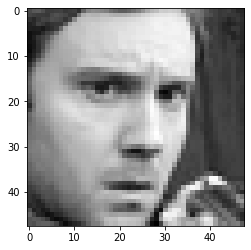

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
ind = 0
f = faces[ind, :,:,0]
print('Emotion Labels', emotions[ind,:])
plt.imshow(f, cmap='gray')

C:\Softwares\Anaconda\envs\tensorflow-gpu\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


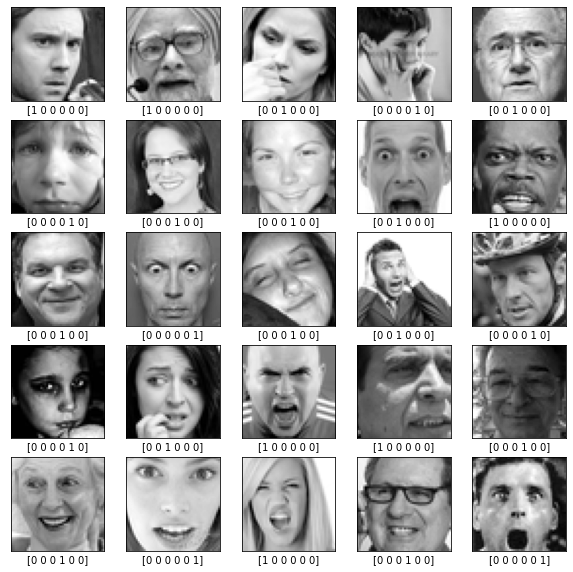

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

# Show first 25 training images below
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(faces[i, :, :, 0], cmap='gray')
    plt.xlabel(emotions[i,:])

In [13]:
faces.shape, emotions.shape

((23744, 48, 48, 1), (23744, 6))

### Building CNN

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### GPU

In [14]:
# import os
# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
# os.environ['CUDA_VISIBLE_DEVICES'] = "" #please put your GPU

In [18]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



# Tensorflow Version


In [16]:
tf.__version__

'2.4.1'

# Training Code

In [23]:
#Model 8 #inspired from AlexNet
model = Sequential([
    Conv2D(filters=96, kernel_size=(3,3), strides=(2,2), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(4,4), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.4),
    Dense(4096, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

In [24]:
model.summary()

In [33]:
# Define your optimizer here
optim = optimizers.Adam(lr=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])


In [36]:
# save the model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='Siti.h5', mode='max', monitor='val_acc', verbose=2, save_best_only=True)
callbacks_list = [checkpoint]

epochs = 10

history = model.fit(
      faces_train, emotions_train,
      epochs=epochs,
      validation_data=(faces_val, emotions_val),
      #validation_steps=validation_generator.n/validation_generator.batch_size,
      verbose = 1,
      callbacks=callbacks_list)

Epoch 1/10
594/594 [==============================] - 30s 46ms/step - loss: 1.8896 - acc: 0.2961 - val_loss: 1.5211 - val_acc: 0.4139

Epoch 00001: val_acc improved from -inf to 0.41389, saving model to Siti.h5
Epoch 2/10
594/594 [==============================] - 30s 50ms/step - loss: 1.3715 - acc: 0.4395 - val_loss: 1.2699 - val_acc: 0.4855

Epoch 00002: val_acc improved from 0.41389 to 0.48547, saving model to Siti.h5
Epoch 3/10
594/594 [==============================] - 30s 50ms/step - loss: 1.2169 - acc: 0.5090 - val_loss: 1.2485 - val_acc: 0.5095

Epoch 00003: val_acc improved from 0.48547 to 0.50947, saving model to Siti.h5
Epoch 4/10
594/594 [==============================] - 30s 50ms/step - loss: 1.0974 - acc: 0.5717 - val_loss: 1.1875 - val_acc: 0.5204

Epoch 00004: val_acc improved from 0.50947 to 0.52042, saving model to Siti.h5
Epoch 5/10
594/594 [==============================] - 28s 47ms/step - loss: 0.9821 - acc: 0.6113 - val_loss: 1.1076 - val_acc: 0.5739

Epoch 00005:

In [37]:
history.history

{'loss': [1.6638556718826294,
  1.3399982452392578,
  1.2048743963241577,
  1.0969651937484741,
  0.9857181906700134,
  0.8847843408584595,
  0.7715839147567749,
  0.661627471446991,
  0.5631520748138428,
  0.4717617928981781],
 'acc': [0.34956568479537964,
  0.4564359188079834,
  0.5171360969543457,
  0.568939208984375,
  0.6138983964920044,
  0.6543300747871399,
  0.6994998455047607,
  0.7470913529396057,
  0.7858383655548096,
  0.8246906995773315],
 'val_loss': [1.521116018295288,
  1.2698618173599243,
  1.2484595775604248,
  1.1874876022338867,
  1.1075870990753174,
  1.2116847038269043,
  1.1965551376342773,
  1.199318528175354,
  1.3077765703201294,
  1.4516019821166992],
 'val_acc': [0.41389474272727966,
  0.4854736924171448,
  0.5094736814498901,
  0.520421028137207,
  0.573894739151001,
  0.5435789227485657,
  0.5692631602287292,
  0.5806315541267395,
  0.577684223651886,
  0.5616841912269592]}

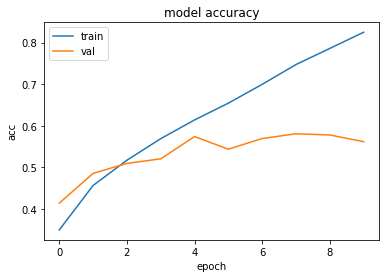

In [38]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Saving the model

In [39]:
# save your model and weight (only submit best model)
best_model = model
model_json = best_model.to_json()
with open("Siti.json", "w") as json_file:
    json_file.write(model_json)
best_model.save_weights('Siti.h5')

# Testing Code

In [40]:
# Your model will be tested as following

# Model reconstruction from JSON file
with open('Siti.json', 'r') as json_file:
    json_savedModel= json_file.read()

test_model = tf.keras.models.model_from_json(json_savedModel)
test_model.summary()

optim = optimizers.Adam(lr=1e-4)

test_model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

# Load weights into the new model
test_model.load_weights('Siti.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 96)        960       
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 256)       393472    
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 384)         8

In [42]:
# ## Testing
# test_loss, test_acc = test_model.evaluate(faces_test/255.0, emotions_test) 
# print('Test accuracy:', test_acc)

In [43]:
## Testing
test_loss, test_acc = test_model.evaluate(faces_test, emotions_test) 
print('Test accuracy:', test_acc)

75/75 [==============================] - 3s 30ms/step - loss: 1.3788 - acc: 0.5619
Test accuracy: 0.558972179889679
